In [31]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pymc.sampling_jax
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import roc_curve, precision_score, recall_score, roc_auc_score, accuracy_score, auc
# from sklearn.calibration import CalibrationDisplay
# import pickle

# import matplotlib.pyplot as plt
# import seaborn as sns

# %config InlineBackend.figure_format = 'retina'
# az.style.use("arviz-darkgrid")

# %load_ext watermark
# %watermark -n -u -v -iv -w -p sklearn

In [22]:
import os

os.chdir("D:/Manal/Programming/project1/Transmission_probability/method3_enveloppes/v_PyMC/")

In [23]:
df = pd.read_excel("Input/v_minutes/under_2m/enveloppe1_0.1_pivot.xlsx")
df1 = pd.read_excel("Input/v_minutes/under_2m/enveloppe1_0.1.xlsx")
y = df1["infected"].to_numpy()

In [24]:
df.head()

,experiment,contact_duration,cap_ID,infected,distance,time
0,1,1h,100,0,1.427346,2
1,1,1h,100,0,0.978005,2
2,1,1h,100,0,0.974849,1
3,1,1h,100,0,1.791249,1
4,1,1h,100,0,1.298035,1


## Exploratory data analysis

In [25]:
df1['infected'].value_counts()

infected
0    48
1    16
Name: count, dtype: int64

In [ ]:
ax = plt.figure(figsize=(3,3))
ax = sns.countplot(x='infected', data=df1, hue='infected', stat='count');

In [27]:
# Pre-calculate unique combinations of experiment and contact_duration
unique_combinations = df[['experiment', 'contact_duration', 'cap_ID']].drop_duplicates()

# Convert to a list of tuples for iteration
unique_combinations = [tuple(x) for x in unique_combinations.to_numpy()]

In [32]:
distances_list = []
times_list = []

for e, c, i in unique_combinations:
    df_temp = df[(df['experiment'] == e) & (df['contact_duration'] == c) & (df['cap_ID'] == i)]
    distances = df_temp['distance'].values
    times = df_temp['time'].values
    distances_list.append(distances)
    times_list.append(times)

# Convertir les listes en matrices numpy de type object
distances_matrix = np.array(distances_list, dtype=object)
times_matrix = np.array(times_list, dtype=object)

In [37]:
with pm.Model() as model:
    # Priors
    p0 = pm.Beta('p0', alpha=1, beta=1)
    lambda_ = pm.LogNormal('lambda', mu=-1, sigma=0.1)
    
    # Calcul vectorisé avec objets numpy de type `object`
    p_temp_list = [(1 - (p0 * pt.exp(-lambda_ * dist))) ** time for dist, time in zip(distances_matrix, times_matrix)]
    p_prod = pt.stack([pt.prod(p_temp) for p_temp in p_temp_list])
    p_list = 1 - p_prod

    p_list_det = pm.Deterministic('p_list', p_list)

    # Likelihood
    y_true = pm.Bernoulli('y_obs', p=p_list, observed=y)

    inits = {'p0': 0.001, 'lambda': 0.1}

In [34]:
p_list

Sub.0

In [38]:
%%time
with model:
    trace = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95, initvals=inits, random_seed=42)

Compiling...
Compilation time = 0:00:34.516080
Sampling...
Sampling time = 0:02:14.252446
Transforming variables...
Transformation time = 0:00:18.032297


CPU times: total: 4min 49s
Wall time: 3min 7s


In [42]:
# Afficher les noms des groupes disponibles dans les données d'inférence
trace


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:

model = pm.Model()
with pm.Model() as model:
    # Priors
    p0 = pm.Beta('p0', alpha=1, beta=1)
    lambda_ = pm.LogNormal('lambda', mu = -1, sigma=0.1)
    p_list = []
    # Loop through data
    for e, c, i in unique_combinations:
        df_temp = df[(df['experiment'] == e) & (df['contact_duration'] == c) & (df['cap_ID'] == i)]
        distances = df_temp['distance'].values
        times = df_temp['time'].values
        p_temp = (1 - (p0 * pm.math.exp(-lambda_ * distances))) ** times   
        p_i = pm.math.prod(p_temp)
        p_list.append(1 - p_i)

    # Likelihood
    y_true = pm.Bernoulli('y_obs', p = p_list, observed=y) 

    inits = {'p0': 0.001, 'lambda': 0.1}


In [ ]:
p_list = []
for e, c, i in unique_combinations:
    df_temp = df[(df['experiment'] == e) & (df['contact_duration'] == c) & (df['cap_ID'] == i)]
    distances = df_temp['distance'].values
    times = df_temp['time'].values
    p_temp = (1 - (0.003 * np.exp(-0.034 * distances))) ** times   
    p_i = np.prod(p_temp)
    p_list.append(1 - p_i)

p_array = np.array(p_list, dtype=np.float64)  # Explicitly set dtype
    #p = pt.as_tensor(p_array)

In [ ]:
p_list

In [ ]:
len(p_list)

In [ ]:
import math
prova=[]
for e, c in unique_combinations:
    df_temp = df[(df['experiment'] == e) & (df['contact_duration'] == c)]
    ids = df_temp['cap_ID'].unique()
        
    # Iterate over unique cap_IDs
    for _, group in df_temp.groupby('cap_ID'):
        distances = group['distance'].values
        times = group['time'].values
        p_temp = (1 - (0.003 * np.exp(-0.034 * distances))) ** times   
        p_i = np.prod(p_temp)
        p = 1 - p_i
        prova.append(p)

In [ ]:
%%time
model = pm.Model()
with pm.Model() as model:
    # Priors
    p0 = pm.Beta('p0', alpha=1, beta=1)
    lambda_ = pm.LogNormal('lambda', mu = -1, sigma=0.1)
    prova=[]
    # Loop through data
    for e, c in unique_combinations:
        df_temp = df[(df['experiment'] == e) & (df['contact_duration'] == c)]
        ids = df_temp['cap_ID'].unique()
        distances = df_temp['distance'].values
        times = df_temp['time'].values
        df_temp['p_temp'] = (1 - (p0 * pm.math.exp(-lambda_ * distances))) ** times  
    
        # Iterate over unique cap_IDs
        for _, group in df_temp.groupby('cap_ID'):
 
            p_i = pm.math.prod(group['p_temp'])
            p = 1 - p_i
            prova.append(p)
    provaarray=np.array(prova)            
    # Likelihood
    y_true = pm.Bernoulli('y_obs', p = prova, observed=y)

    inits = {'p0': 0.001, 'lambda': 0.1}


In [ ]:
%%time
with model:
    trace = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95, initvals=inits, random_seed=42)

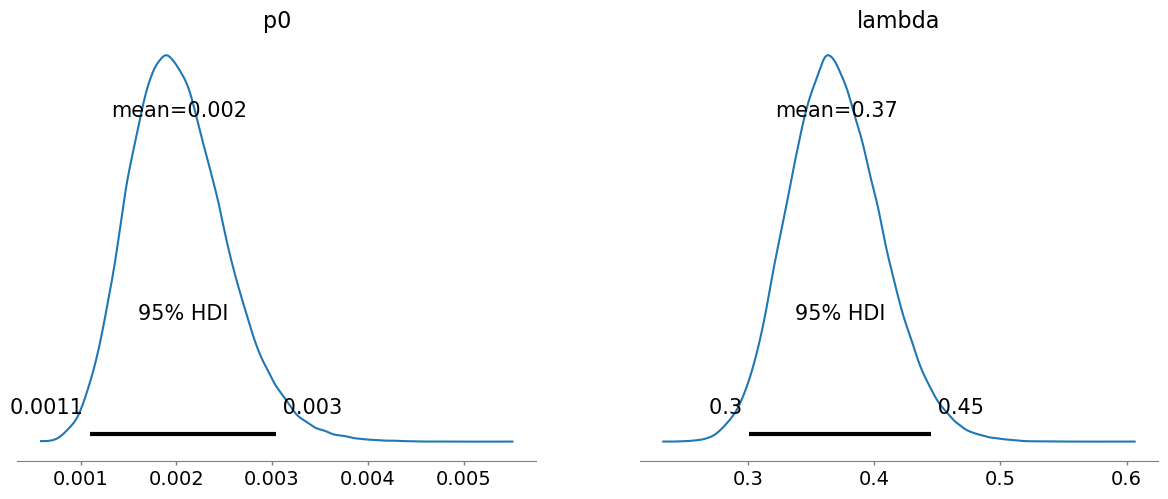

In [44]:
az.plot_posterior(trace, var_names=["p0", "lambda"], hdi_prob=.95);

In [45]:
az.summary(trace, round_to=4, hdi_prob=.95)

c:\Users\U117-T408\anaconda3\envs\tf\lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p0,0.0020,0.0005,0.0011,0.0030,0.0000,0.0000,60750.1213,54918.7047,1.0002
lambda,0.3698,0.0371,0.3010,0.4454,0.0002,0.0001,60735.8119,59640.8184,1.0001
p_list[0],0.0436,0.0105,0.0241,0.0645,0.0000,0.0000,63754.2820,55630.6356,1.0001
p_list[1],0.0665,0.0158,0.0371,0.0980,0.0001,0.0000,63458.3230,55409.8012,1.0001
p_list[2],0.0713,0.0169,0.0399,0.1050,0.0001,0.0000,63254.6267,55264.0772,1.0001
...,...,...,...,...,...,...,...,...,...
p_list[59],0.1376,0.0313,0.0794,0.2005,0.0001,0.0001,63977.0135,55682.6725,1.0001
p_list[60],0.0654,0.0156,0.0360,0.0959,0.0001,0.0000,64594.3679,55930.5641,1.0001
p_list[61],0.1911,0.0420,0.1118,0.2746,0.0002,0.0001,63839.3731,55669.8637,1.0001
p_list[62],0.3569,0.0692,0.2220,0.4915,0.0003,0.0002,62973.8228,55212.9335,1.0002


In [ ]:
with open('Output2/trace_enveloppe_2m_0.1.pkl', 'wb') as f:
    pickle.dump(trace, f)

In [ ]:
with open('Output/trace_enveloppe_2m_0.1.pkl', 'rb') as f:
    trace = pickle.load(f)

In [46]:
# extract samples from the trace

samples = trace.posterior.stack(sample=("chain", "draw"))

# select a random sample from the trace
selected_samples = np.random.choice(range(len(samples['p0'])), size=5000, replace=False)

# extract the values of the parameters
p0_sample = samples['p0'].values[selected_samples]
lambda_sample = samples['lambda'].values[selected_samples]

In [ ]:
# Initialize the list for predictions
pred = []

status = []

# Iterate over samples
for j in range(len(lambda_sample)):
    a = lambda_sample[j]
    b = p0_sample[j]
    
    
    status_temp = []
    
    # Iterate over unique combinations of experiment and contact_duration
    for e, c in unique_combinations:
        df_temp = df[(df['experiment'] == e) & (df['contact_duration'] == c)]
        ids = df_temp['cap_ID'].unique()
        pred_status = []

        pred_parametre = []
        # Iterate over unique cap_IDs
        for id in ids:
            p_i = 1
            datai = df_temp[df_temp['cap_ID'] == id]
            distances = datai['distance'].values
            times = datai['time'].values
            
            # Vectorized calculation of p_temp
            p_temp = (1 - (b * np.exp(a * distances))) ** times
            
            # Product of probabilities for the cap_ID
            p_i = np.prod(p_temp)
            
            # Append the final calculation for the cap_ID
            pred_parametre.append(1 - p_i)

            #pred_status.append(np.random.binomial(1, 1-p_i))

        pos = sum(pred_status)
        pmean=np.mean(pred_parametre)
        status_temp.append(np.random.binomial(len(pred_parametre), pmean))
    
    # Append predictions for this sample
    #pred.append(pmean)

    status.append(status_temp)

In [ ]:
print(status)

In [ ]:
simulations_cases = pd.DataFrame({f'Sim{i+1}': sublist for i, sublist in enumerate(status)})

simulations_cases.head(11)

simulations_cases.to_csv('cases_per_exp_envelope_v2.csv', index=False)

In [ ]:
concatenated_cols = pd.concat([df1["experiment"], df1["contact_duration"], df1["infected"]], axis=1)
concatenated_df = pd.concat([concatenated_cols, simulations_cases], axis=1)

concatenated_df = concatenated_df.reset_index()

concatenated_df.head()

In [ ]:
simulations_proba = pd.DataFrame({f'y_pred{i+1}': sublist for i, sublist in enumerate(pred)})

simulations_bernoulli = simulations_proba.map(lambda prob: np.random.binomial(1, prob))

In [ ]:
concatenated_cols = pd.concat([df1["experiment"], df1["contact_duration"], df1["infected"]], axis=1)

concatenated_df = pd.concat([concatenated_cols, simulations_bernoulli], axis=1)

concatenated_df = concatenated_df.reset_index()

concatenated_df.head()

In [ ]:
grouped_df = concatenated_df.groupby(['experiment', 'contact_duration']).sum().reset_index()

grouped_df.head()

grouped_df.to_csv('number of cases per experiment_enveloppe_2m.csv', index=False)

In [ ]:
proportions = simulations_bernoulli.mean(axis=1)
df_proportions = pd.DataFrame(proportions, columns=['y_pred'])
df_proportions.insert(0, 'y_true', y)
simulations_proba.insert(0, 'y_true', y)

In [ ]:
y_true = df_proportions['y_true']
y_pred = df_proportions['y_pred']

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: enveloppes model, d <= 2 m , threshold = 0.1')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve: enveloppes model, d <= 2 m , threshold = 0.1')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert probabilities to binary predictions
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

# Now you can compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: enveloppes, d <= 2 m & threshold=0.1')
plt.show()

In [ ]:
df1['animal_ID'] = df1['experiment'].astype(str) + '_' + df1['contact_duration'].astype(str) + '_' + df1['cap_ID'].astype(str)

In [ ]:
df_proportions.insert(0, 'animal_ID', df1['animal_ID'])

In [ ]:
df_proportions.sort_values(by=['y_true', 'animal_ID'], ascending= True, inplace=True)
df_proportions.to_excel('Output2/df_proportions_2m_0.1.xlsx', index=False)

In [ ]:
df_proportions = pd.read_excel("Output2/df_proportions_2m_0.1.xlsx")

In [ ]:
# Créer une figure et un axe
fig, ax = plt.subplots(figsize = (20, 8))

# Tracer les points pour y_true et y_pred
ax.scatter(df_proportions['animal_ID'], df_proportions['y_true'], color='blue', label='Real observations')
ax.scatter(df_proportions['animal_ID'],df_proportions['y_pred'], color='red', label='Predicted probabilities')
ax.plot(df_proportions['animal_ID'], df_proportions['y_pred'], color='red')
ax.axhline(0.5, color='gray', lw=2, linestyle='--', label= 'y_pred=0.5')

# Tracer les boîtes entre y_true et y_pred
for i in range(len(df_proportions)):
    ax.plot([df_proportions['animal_ID'].iloc[i]]*2, [df_proportions['y_true'].iloc[i], df_proportions['y_pred'].iloc[i]], color='black')

# Définir les limites de l'axe des y
ax.set_ylim([0, 1])

for label in ax.get_xticklabels():
    label.set_rotation(90)

# Ajouter une légende
ax.legend()
plt.title("Real VS Predicted: enveloppes model, distance <= 2 m, threshold=0.1")
plt.xlabel("Animal Identifier")

plt.show()

In [ ]:
def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    auc = roc_auc_score(true_y, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:0.4f})')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: enveloppes 2m , seuil = 0.1')
    plt.legend(loc="lower right")

In [ ]:
aucs = []

# Boucle sur chaque colonne d'estimations
for col in simulations_proba.columns[1:] : # Commencer à partir de la deuxième colonne car la première est y_true
    y_pred = simulations_proba[col]
    auc = roc_auc_score(y_true, y_pred)
    aucs.append(auc)


In [ ]:
mean_auc = np.mean(aucs)
median_auc = np.median(aucs)

print("mean auc:", mean_auc)
print("median auc:", median_auc)

q1 = np.quantile(aucs, 0.25)
q3 = np.quantile(aucs, 0.75)

if q3 == q1: 
   print("Not enough data")
else:
   iqr = q3 - q1  
   lower = q1 - 1.5 * iqr
   upper = q3 + 1.5 * iqr 
   conf_interval = (lower, upper)

   print(conf_interval)

In [ ]:
# Trouver l'indice du maximum dans la liste d'AUC
indice_max_auc = np.argmax(aucs)

# Récupérer la colonne d'estimation avec le maximum d'AUC
col_max_auc = simulations_proba.columns[indice_max_auc + 1]  # +1 pour compenser la première colonne (y_true)

# Afficher la colonne d'estimation avec le maximum d'AUC
print(f"La colonne avec le maximum d'AUC est : {col_max_auc}")

In [ ]:
y_pred = simulations_proba['y_pred342']

In [ ]:
plot_roc_curve(y_true, y_pred)

In [ ]:
# Plot histogram  
plt.hist(y_true, bins=30, density=True)
plt.hist(y_pred, bins=30, density=True)
plt.vlines(y_pred.mean(), 0, 0.4, colors='r') 

plt.xlabel('Sampled θ')  
plt.ylabel('Density')
plt.title('Real vs Predicted : enveloppes 2m , seuil = 0.1 ')
   
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred > 0.5) 
print(accuracy)

In [ ]:
from sklearn.metrics import precision_score, recall_score  

precision = precision_score(y_true, y_pred > 0.5)  
recall = recall_score(y_true, y_pred > 0.5)

print(precision, recall)

In [ ]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_predictions(y_true, y_pred)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

specificity = 1 - fpr
plt.plot(specificity, tpr, color='green', label='Sensitivity')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Sensitivity/Specificity Curve')
plt.legend(loc="lower right")
plt.show()

# Posterior analysis

In [ ]:
az.plot_trace(trace, combined=True);

In [ ]:
az.summary(trace, round_to=6)

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
az.plot_energy(trace);

# Model log-likelihood

In [ ]:
with model:
    pm.compute_log_likelihood(trace)

In [ ]:
model_loo = az.loo(trace)

model_loo

In [ ]:
model_waic = az.waic(trace)

model_waic

In [ ]:
# Generate posterior predictive samples
with model:
    pm.sample_posterior_predictive(trace, random_seed=42, extend_inferencedata=True)

In [ ]:
trace.posterior_predictive

In [ ]:
az.plot_ppc(trace, num_pp_samples=1000, kind = 'kde', group="posterior");

In [ ]:
az.plot_ppc(trace, num_pp_samples=1000, kind = 'cumulative');

In [ ]:
az.plot_ppc(trace, num_pp_samples=5, kind = 'scatter');

In [ ]:
az.plot_autocorr(trace, var_names=["p0", "lambda"]);

In [ ]:
# Gelman-Rubin convergence diagnostic
r_hat = az.rhat(trace, var_names=["p0", "lambda"])
print(r_hat)

In [ ]:
ess = az.ess(trace, var_names=["p0", "lambda"])
ess

In [ ]:
az.plot_ess(trace, var_names=["p0", "lambda"], kind="evolution");

In [ ]:
total_ess = ess["p0"].sum().values
print(f"Total effective sample size for p0: {float(total_ess):.2f}")

In [ ]:
total_ess = ess["lambda"].sum().values
print(f"Total effective sample size for lambda: {float(total_ess):.2f}")